# Decoding Individual Identity
Tim Tyree<br>
9.9.2022

(~5-10 minute read)

In [1]:
from lib.get_init import *
%load_ext autoreload
%autoreload 2
np.random.seed(42)

In [2]:
#reset matplotlib settings
sns.reset_orig()
mpl.rc_file_defaults()

# select the data

In [3]:
#optionally, use a popup window to select data.json
use_search_dialog=False
if use_search_dialog:
    from lib.controller.filedialog import search_for_file
    #nota bene: restarting the .ipynb should make the widget window go away
    data_dir = search_for_file (currdir = os.getcwd())
else:
    data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'


In [4]:
print(f"{data_dir=}")
assert os.path.exists(data_dir)

data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'


# load the data

_schema of data.json:_
- observer_name: name of the observer
- session_num: integer index of recording session
- dict_anatomical: anatomical information for recording session
- dict_relationships: relationship information confirmed between observers and conspecifics
- dict_transcript: spike times for all neurons labeled by trial, trial information
    - spike_time_array: table containing neuron spike times centered at stimulus onset t=0. rows index trials. columns index neurons.
    - df_trial_data: table of trial information. rows index trials.
    - df_labels: table of trial labels computed from trial information. rows index trials.
- dict_error_estimates: estimated spike sorting error rates (percent of oversplit or undersplit neurons)
- dict_subpopulations: dictionary of neurons identified as concept cells or responsive to face or voice stimuli
- dict_decoder_hyperparameters: dictionary of decoder hyperparameter settings
- dict_etc:
    - df_neurons: table of information describing all neurons.  rows index neurons.
    - dict_spike_templates: dictionary of spike sorting templates for all neurons.
        - t_values: time values centered at the waveform peak
        - dict_spike_template_lst: list spike template dictionaries ordered by neuron
        - xdim: units of t_values are in milliseconds.
        - ydim: units of spike templates are in millivolts.
        - flip_signs: true if original spike template was multiplied by -1, which typically lead to spikes appearing as a maximum instead of as a minimum value.

In [5]:
#load data from .json
data=load_from_json(data_dir)
observer_name = data['observer_name']
session_num = data['session_num']
print(f"This dataset was loaded from {data_dir=}.")
print(f"\nObserver: {observer_name.capitalize()} (Session #{session_num+1})") #using session_num+1 here bc the first recording session had session_num=0.
print(f"\n------------------------------\n")
print(f"\ndata has the following keys:")
# print(*data)
for key in data:
    print(key)
print(f"\ndict_anatomical holds anatomical data for recoring session:")
print_dict(data['dict_anatomical'])

This dataset was loaded from data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'.

Observer: Hades (Session #46)

------------------------------


data has the following keys:
session_num
observer_name
dict_anatomical
dict_relationships
dict_transcript
dict_error_estimates
dict_subpopulations
dict_decoder_hyperparameters
dict_etc

dict_anatomical holds anatomical data for recoring session:
session_num=45
anatomical_region='CA1'
AP_pos_set=-3.1


__Anatomical location in Hippocampus:__

The estimated centroid of the microwire brush array was used to determine anatomical location of a recording session.  The anterior-posterior (`AP_pos`) position was estimated (in millimeters), and if we had great confidence that the majority of the array was recording predominantly in one hippocampal 
subfield, then we labeled the recording session with the appropriate subfield (`anatomical_region`).  If `anatomical_region=''`, then we did not have this great confidence for any of the subfields located in the hippocampus.

__Nota bene__: <br>The recording session previous to Session #47 (Session #46) was prodominantly in CA1 (i.e. `anatomical_region='CA1`).

<!--  ![image.png](attachment:image.png). -->

In [6]:
print(f"dict_transcript has the following keys:")
for key in data['dict_transcript']:
    print(key)
    
#load spike data from the dict_transcript
spike_time_array = np.array(data['dict_transcript']['spike_time_array'])
#caste spike time array to numpy.array of numpy.array instances
for i in range(spike_time_array.shape[0]):
    for j in range(spike_time_array.shape[1]):
        if type(spike_time_array[i,j])==float:
            spike_time_array[i,j] = np.array([spike_time_array[i,j]])
        else:
            spike_time_array[i,j] = np.array(spike_time_array[i,j])

#load trial data from from the dict_transcript
df_trial_data = pd.DataFrame(data['dict_transcript']['df_trial_data'])\
    .drop(columns=['PheeName','index'])\
    .reset_index(drop=True)  # ^those were redundant
df_labels = pd.DataFrame(data['dict_transcript']['df_labels'])\
    .reset_index(drop=True)
df_trial_data.head()

dict_transcript has the following keys:
spike_time_array
df_trial_data
df_labels


,Duration,block,imDur,imMatchFlag,imName,imNum,novel,session_num,trial_num,monkName,faceName,pheeName
0,2.590260,1.0,2.590260,3.0,none,1.0,1,45,0,Hades,none,chewie
1,3.503553,1.0,3.503553,0.0,Jenny,2.0,1,45,1,Hades,jenny,none
2,3.507905,1.0,3.507905,0.0,Chewie,3.0,1,45,2,Hades,chewie,none
3,3.502131,1.0,3.502131,0.0,Hermes,4.0,1,45,3,Hades,hermes,none
4,2.666507,1.0,2.666507,3.0,none,5.0,1,45,4,Hades,none,hank


# count spikes by both neuron and trial

In [30]:
#count the number of spikes in each trial for each neuron
min_refractory_period = 1/150 #150 Hz max firing rate
spike_count_array,error_code_array = count_spike_count_errs(spike_time_array,
                                    min_refractory_period = min_refractory_period)

In [45]:
#generate xy coordinate grids
num_trials,num_neurons = error_code_array.shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array.copy().T
zerr=error_code_array.copy().T

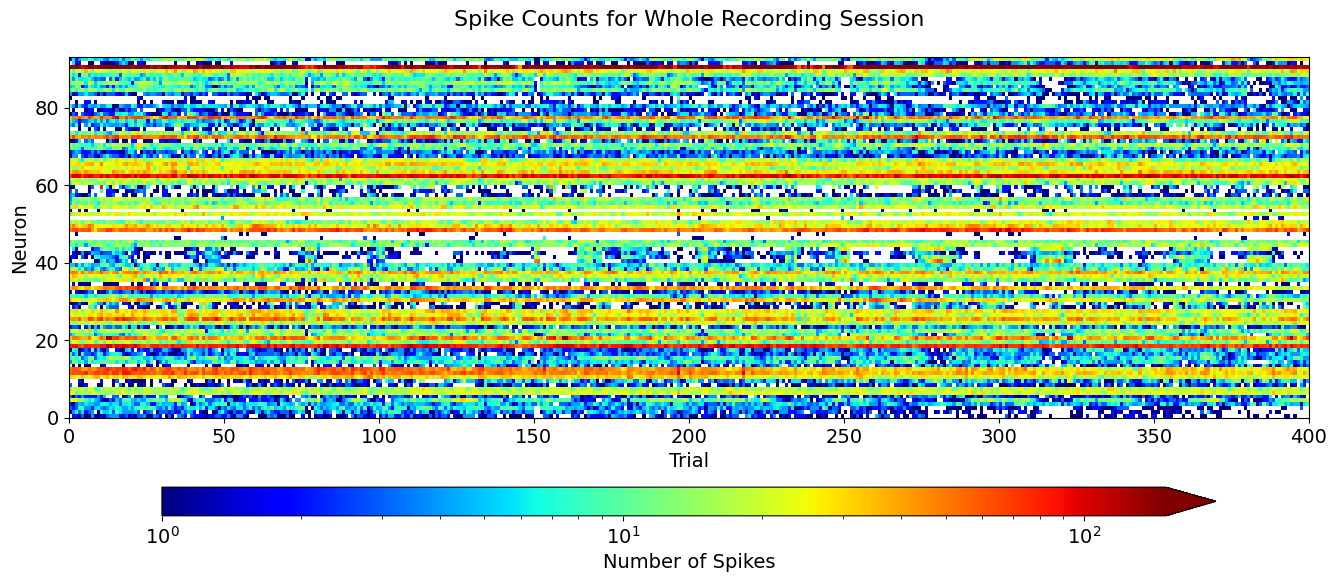

In [46]:
#visualize heatmap showing the number of spikes per trial,neuron pair
title = 'Spike Counts for Whole Recording Session\n'
vmin=1.
vmax=150.
figsize=(16,6)
cmap='jet'#'PuBu_r'#
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')#,**kwargs)
plt.show()

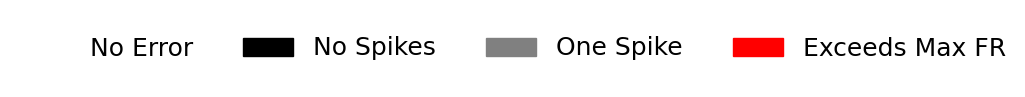

In [10]:
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'Exceeds Max FR'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, 
                                               colors=list(dict_error_colors.values()), 
                                               extend='neither')
#show legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18}
PlotLegend(label_lst=label_lst,color_lst=color_lst,**kwargs_legend);

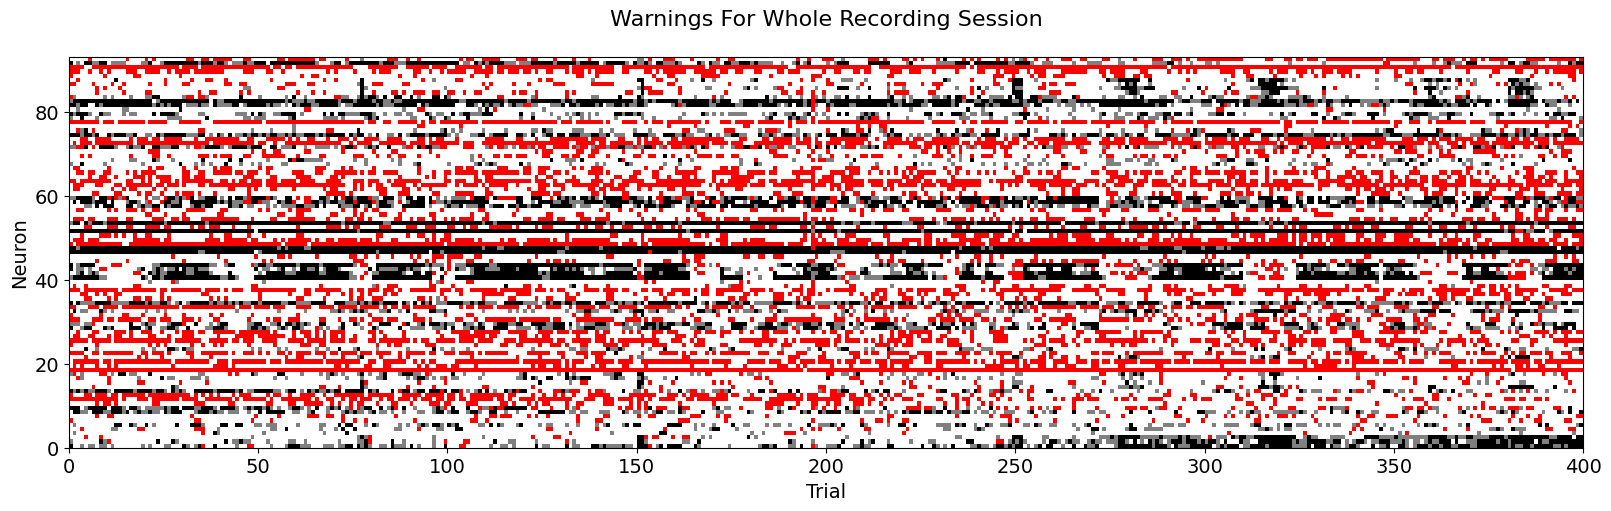

In [11]:
#visualize heatmap showing error codes of any neuron pair
title = 'Warnings For Whole Recording Session\n'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=fontsize,xlabel='Trial',ylabel='Neuron')#,**kwargs)
plt.show()

# identify any obvious recording errors that warrant removal

Obvious recording errors to look out for: 

1. (red vertical bars) trials that are common to all or nearly all neurons and 

1. (red horizontal bars) neurons that do not fire for an entire recording block or more.

1. (black horizontal bars) neurons that do not fire for an entire recording block or more.


In [12]:
max_block_size = pd.DataFrame(data['dict_transcript']['df_trial_data']).groupby(by='block').count().max().values[0]
print(f"{max_block_size=} trials")

max_block_size=20 trials


## red horizontal bar trials

identify trials and neurons with unreasonably high firing rates for an overwhelming majority of the trials.<br>
doing so can potentially identify severly undersplit neurons.

In [13]:
#choose filter for trials that fired unreasonably fast (error_code==3)
max_count_err_3_by_trial=75
count_err_3_by_trial  = np.sum (error_code_array==3,axis=1)

# boot is True when trial is to be removed
boot = (count_err_3_by_trial  > max_count_err_3_by_trial).flatten()

#generate list of trials to be removed
trial_num_values_reasonable  = np.argwhere(~boot).flatten()
trial_num_values_unreasonable = np.argwhere(boot).flatten()
num_trials_reasonable  = trial_num_values_reasonable.shape[0]
num_trials_unreasonable = trial_num_values_unreasonable.shape[0]
print(f"\t{num_trials_reasonable=} (keep) \t{num_trials_unreasonable=} (remove)")

	num_trials_reasonable=400 (keep) 	num_trials_unreasonable=0 (remove)


## undersplit type neurons (multiunits)

the results in the main text were robust to multiunits identified by low to moderate abundances of interspike intervals <br>
that are briefer than the minimum refractory period.  this supports some multiunits as carrying meaningful information.  

however, there is reason to believe that severely undersplit neurons can increase trial-to-trial variance, <br>
which will inhibit/hinder any randomized predictive study, which warrants their removal.

In [14]:
#choose filter for neurons that are unreasonable (error_code==3 too often)
max_count_err_3_by_neuron=300
count_err_3_by_neuron = np.sum (error_code_array==3,axis=0)
boon3 = count_err_3_by_neuron > max_count_err_3_by_neuron
print(f"\tnum_neurons_reasonable={boon3.shape[0]-sum(boon3)} (keep), \tnum_neurons_unreasonable={sum(boon3)} (remove)")

	num_neurons_reasonable=86 (keep), 	num_neurons_unreasonable=7 (remove)


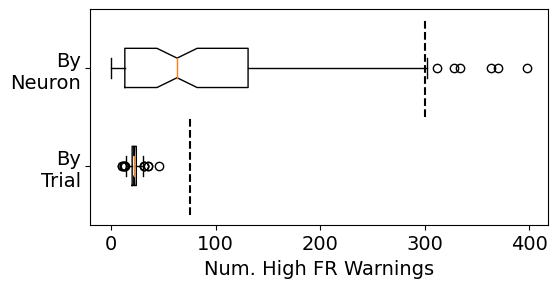

In [15]:
x1_values=count_err_3_by_trial#/num_trials
x2_values=count_err_3_by_neuron#/num_neurons
x1_thresh=max_count_err_3_by_trial
x2_thresh=max_count_err_3_by_neuron
x1_label='By\nTrial'
x2_label='By\nNeuron'
figsize=(5.9,2.8)
fig,ax=plt.subplots(figsize=figsize)
#plot thresholds
ax.plot([x1_thresh,x1_thresh],[-0.5,0.5],'k--')
ax.plot([x2_thresh,x2_thresh],[0.5,1.5],'k--')
#plot boxplots
ax = BoxplotPairPlotter_simple(ax,x1_values,x2_values,x1_label,x2_label,position1=0,position2=1,
                              xlabel='Num. High FR Warnings',ylabel='',fontsize=14)#,vert=False,notch=True,widths=0.4,manage_ticks=False)#,**kwargs)
plt.show()

to address (2.), we counted the number of times a neuron fires faster than the estimated minimum refractory period.<br>
Q: does (lower black dotted) max_count_err_3_by_neuron look reasonable for this recording session?


## oversplit type neurons (deadunits)

increasing max_streak_length geneerally increases the number of neurons removed for not firing.  neurons might stop firing for long periods of time if they die, the monkey moved the wrong way between recording blocks, or if the neuron was severely oversplit.

In [16]:
#identify unreasonably low firing rates
df_es = identify_obvious_recording_warnings_from_session(error_code_array,spike_count_array,
                                             max_count_err_3_by_trial=max_count_err_3_by_trial,
                                             max_count_err_3_by_neuron=max_count_err_3_by_neuron,
                                             printing=True)
print(f"Q: did some neurons failed to fire for many recording sessions in a row?...\n\t\t\t...if so, they should be removed from further consideration.")
print(f"\nany recording block had no more than these many trials:")
print(f"\t\t\t{max_block_size=}")
df_es.sort_values(by='longest_error_streak',ascending=False).head(10)

Q: did some neurons failed to fire for many recording sessions in a row?...
			...if so, they should be removed from further consideration.

any recording block had no more than these many trials:
			max_block_size=20


,nid,longest_error_streak,final_error_streak,max_spike_count
41,41,126,8,6
46,46,68,20,7
45,45,64,1,3
39,39,37,12,2
49,49,27,10,38
52,52,25,11,66
10,10,21,0,11
51,51,17,3,26
34,34,16,0,20
11,11,15,0,8


In [17]:
#identify neurons that fail to fire for too many consecutive trials
max_streak_length=26 # trials
#if there are ≥ the half max_streak_length of consecutively zero spikes at the end, then mark the neuron for removal
boon1 = (df_es['final_error_streak']>max_streak_length/2).values
#if there are ≥ the max_streak_length of consecutively zero spikes, then mark the neuron for removal
boon1|= (df_es['longest_error_streak']>max_streak_length).values

# boon is True when neuron is to be removed
boon = (boon1 | boon3).flatten() 

#generate list of acceptable for neurons that are not obviously unreasonable
nid_values_reasonable = np.argwhere(~boon).flatten()
nid_values_unreasonable = np.argwhere(boon).flatten()
num_neurons_reasonable  = nid_values_reasonable.shape[0]
num_neurons_unreasonable = nid_values_unreasonable.shape[0]
print(f"\t{num_neurons_reasonable=} (keep) \t{num_neurons_unreasonable=} (remove)")

#test there is at least one reasonable neuron remaining
assert nid_values_reasonable.shape[0]>0

	num_neurons_reasonable=81 (keep) 	num_neurons_unreasonable=12 (remove)


##

# identify individuals with sufficient trials

In [18]:
#count the number of trials in each modality.
trial_num_values_face_only = df_trial_data[df_trial_data['pheeName']=='none']['trial_num'].values
trial_num_values_voice_only = df_trial_data[df_trial_data['faceName']=='none']['trial_num'].values
boo_xmod = (df_trial_data['faceName']!='none') & (df_trial_data['pheeName']!='none')
trial_num_values_match = df_trial_data[boo_xmod&(df_trial_data['faceName']!=df_trial_data['pheeName'])]['trial_num'].values
trial_num_values_mismatch = df_trial_data[boo_xmod&(df_trial_data['faceName']==df_trial_data['pheeName'])]['trial_num'].values
print(f"number of trials by mode:")
print(f"\t- {trial_num_values_face_only.shape[0]} (face-only)")
print(f"\t- {trial_num_values_voice_only.shape[0]} (voice-only)")
print(f"\t- {trial_num_values_match.shape[0]} (identity match)")
print(f"\t- {trial_num_values_mismatch.shape[0]} (identity mismatch)")
#count abundance of concepts/the number of times an individual is depicted
df_concept_count = count_abundance_concepts(df_labels,boot,printing=True)
print(f"\t\tcount: {df_concept_count.shape[0]}")

number of trials by mode:
	- 156 (face-only)
	- 58 (voice-only)
	- 110 (identity match)
	- 76 (identity mismatch)
all individuals presented:
		['aladdin', 'ares', 'chewie', 'copper', 'dip', 'han', 'hank', 'hermes', 'jasmine', 'jenny', 'mowgli', 'poseidon', 'rajah', 'waylon']
		count: 14


In [51]:
min_num_appearances=40
min_num_match=3
# min_num_match=8

#select concepts to be considered
booc =df_concept_count['num_appearances']>=min_num_appearances
booc&=df_concept_count['num_match']>=min_num_match
concept_name_values_selected = df_concept_count[booc]['concept_name'].values
print(f"individuals selected with sufficient trials: {concept_name_values_selected}")

individuals selected with sufficient trials: ['aladdin' 'ares' 'chewie' 'dip' 'hank' 'hermes' 'jasmine']


## visualize spike counts of remaining neurons and trials

In [52]:
#generate xy coordinate grids
num_trials,num_neurons = error_code_array[~boot.flatten()][:,~boon.flatten()].shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array[~boot.flatten()][:,~boon.flatten()].copy().T
zerr=error_code_array[~boot.flatten()][:,~boon.flatten()].copy().T
print(f"number of remaining neurons: {num_neurons}")
print(f"number of remaining trials: {num_trials}")

number of remaining neurons: 81
number of remaining trials: 400


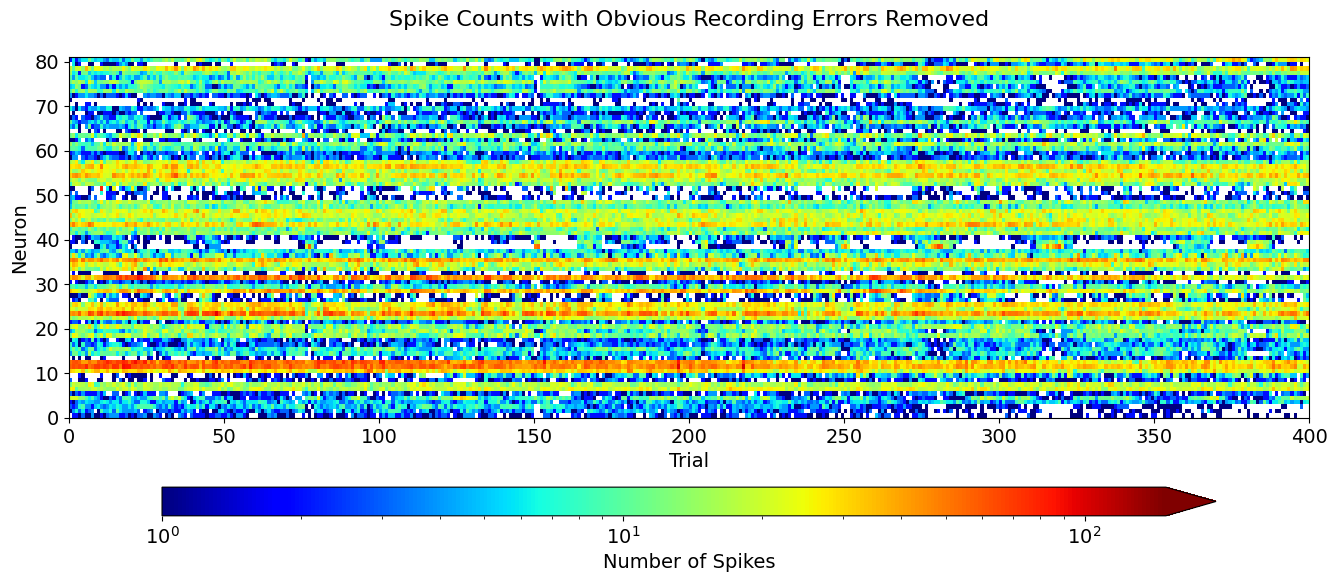

In [53]:
#visualize heatmap showing the number of spikes per trial,neuron pair
title = 'Spike Counts with Obvious Recording Errors Removed\n'
vmin=1.
vmax=150.
figsize=(16,6)
cmap='jet'#'PuBu_r'#
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')#,**kwargs)
plt.show()

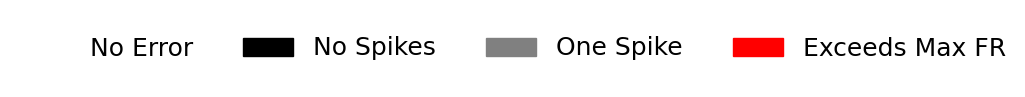

In [54]:
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'Exceeds Max FR'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, 
                                               colors=list(dict_error_colors.values()), 
                                               extend='neither')
#show legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18}
PlotLegend(label_lst=label_lst,color_lst=color_lst,**kwargs_legend);

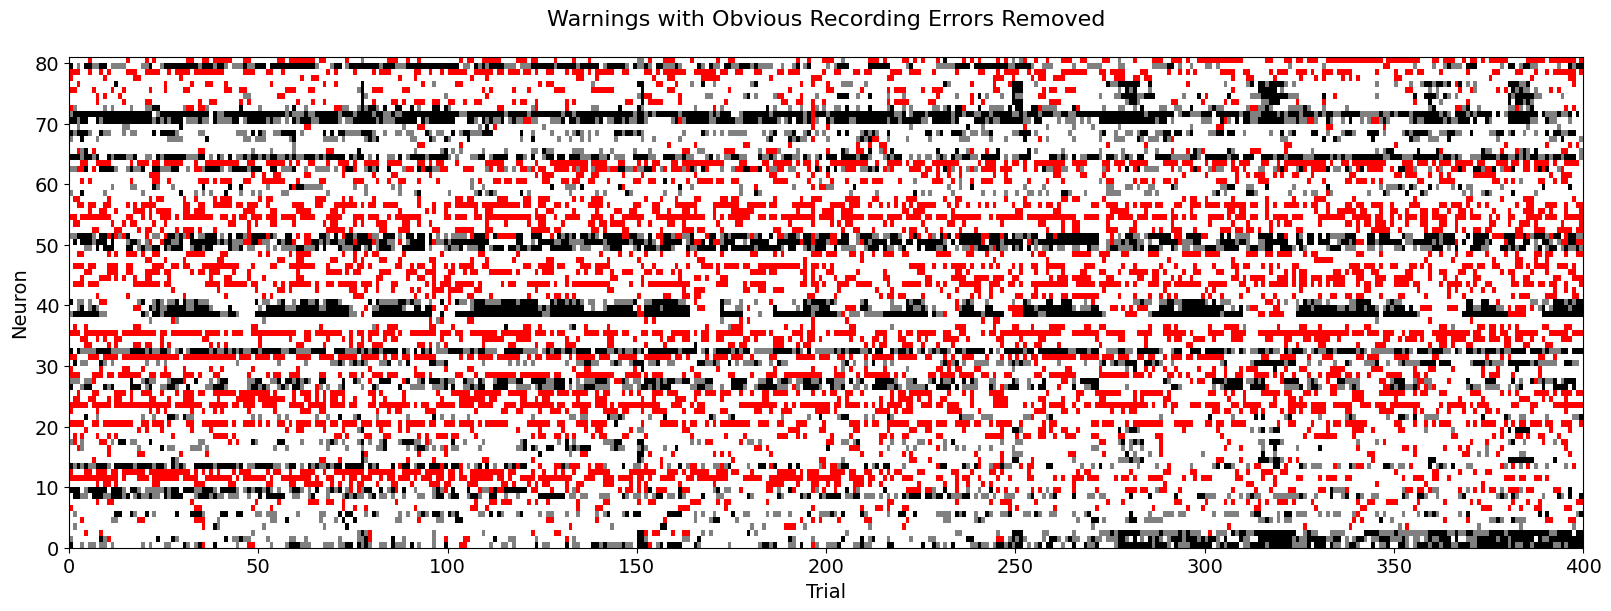

In [55]:
#visualize heatmap showing error codes of any neuron pair
title = 'Warnings with Obvious Recording Errors Removed\n'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=fontsize,xlabel='Trial',ylabel='Neuron')#,**kwargs)
plt.show()

# randomly split trials into train and test sets

use train_test_split_multimodal_crossval to perform the train-test split, which
- uses stratified cross-validation,
- stratifies by depicted stimulus identity, and
- is performed statistically independently on each modality.

In [20]:
n_splits=8
shuffle=True
random_state=42

#perform train test split
df_labels = train_test_split_multimodal_crossval(concept_name_values_selected,df_labels,
                                         trial_num_values_remove=trial_num_values_unreasonable,
                                         n_splits=n_splits,shuffle=shuffle,random_state=random_state)
boo=False
for col in ['cv_fold_face_only', 'cv_fold_voice_only', 
            'cv_fold_match', 'cv_fold_mismatch']:
    boo |= df_labels[col]>-1
num_trials=sum(boo)
print(f"number of trials involved in cross-validation stratified over both identity and modality: {num_trials}")

number of trials involved in cross-validation stratified over both identity and modality: 277


# generate time bins for an individual

## select an indivdual

In [21]:
concept_name_trgt='hermes'
task_str_trgt = f'i_{concept_name_trgt}' 
print(f"identity selected for decoding: {concept_name_trgt.capitalize()}")

identity selected for decoding: Hermes


## generate time bins for identity-specific classification

We will be using gener_tbins_fast to generate candidate time bins.

In [22]:
print (gener_tbins_fast.__doc__)

gener_tbins_fast returns a tuple of df_tbins and df_tbins_refined, respectively.
    booT,booF are boolean index arrays indexing the true/false training trials, respectively.
    spike_time_array is a 2D numpy array instance of list objects that contain spike times for a given trial-neuron pair.
    decreasing max_dur_overlap may needlessly remove useful predictive time bins,
    so its default value is set arbitrarily large while remaining small enough to be a float32 instance.
    using refinement may add ~2minutes to the estimated run time (default: refinement=True).
    otherwise, gener_tbins_fast can run in tpyically less than 2 minutes per call.

    Parameters Settings
    --------------------
        nid_values: neuron index values to consider.  all neurons are considered if nid_values is None (default: nid_values=None)

        taumin: earliest start time

        taumax: latest end time

        delta_tau_min: time between two start/end times

        refinement: whetehr or n

In [24]:
#define the list of time bin search tasks
task_lst=[]
#for each cv_iteration
for cv_iter in range(n_splits):
    #identify the training trials for the fold
    boo_face_train = (df_labels['cv_fold_face_only']>-1) & (df_labels['cv_fold_face_only']!=cv_iter)
    boo_voice_train = (df_labels['cv_fold_voice_only']>-1) & (df_labels['cv_fold_voice_only']!=cv_iter)
    boo_match_train = (df_labels['cv_fold_match']>-1) & (df_labels['cv_fold_match']!=cv_iter)
    boo_mismatch_train = (df_labels['cv_fold_mismatch']>-1) & (df_labels['cv_fold_mismatch']!=cv_iter)
    #identify the training trials
    boo_xmod_train = boo_match_train.values | boo_mismatch_train.values
    boo_train = boo_xmod_train | boo_face_train.values | boo_voice_train.values
    num_xmod_train = np.sum(boo_xmod_train)
    num_train = np.sum(boo_train)
    #task for the match versus mismatch (MvMM) predictive population
    task_str='MvMM'
    #identify the boolean indices for training trials for the individual concept decoder involving the individual
    booT= ((df_labels[f'y_{task_str}']==1)&boo_xmod_train).values
    booF= ((df_labels[f'y_{task_str}']==0)&boo_xmod_train).values
    #identify the boolean indices for testing trials for the individual concept decoder involving the individual
    boo_xmod = (df_labels['y_xmod']==1) # & boo_reasonable
    boo_cv   = (df_labels['cv_fold_match']==cv_iter)|(df_labels['cv_fold_mismatch']==cv_iter)
    booT_test= ((df_labels[f'y_{task_str}']==1)&boo_xmod&boo_cv).values
    booF_test= ((df_labels[f'y_{task_str}']==0)&boo_xmod&boo_cv).values
    booT_all= booT_test | booT
    booF_all= booF_test | booF
    task=dict(spike_time_array=spike_time_array.copy(),
              booT=booT.copy(),booF=booF.copy(),nid_values_reasonable=nid_values_reasonable.copy(),
              booT_test=booT_test.copy(),booF_test=booF_test.copy(), task_str=task_str, cv_iter=int(cv_iter))
    task_lst.append(task)
    #task for each individual
    concept_label=0
    concept_label_lst=[]
    for concept_name in concept_name_values_selected:
        concept_label+=1
        #task for each identity-specific predictive population
        task_str=f'i_{concept_name}'
        #identify the boolean indices for training trials for the individual concept decoder involving the individual
        booT= ((df_labels[f'y_{task_str}']==1)&boo_train).values
        booF= ((df_labels[f'y_{task_str}']==0)&boo_train).values
        #identify the boolean indices for testing trials for the individual concept decoder involving the individual
        boo_cv_i   = (df_labels['cv_fold_face_only']==cv_iter)|(df_labels['cv_fold_voice_only']==cv_iter)
        boo_cv_ = boo_cv_i | boo_cv
        booT_test= ((df_labels[f'y_{task_str}']==1)&boo_cv_).values
        booF_test= ((df_labels[f'y_{task_str}']==0)&boo_cv_).values
        booT_all= booT_test | booT
        booF_all= booF_test | booF
        task=dict(spike_time_array=copy.deepcopy(spike_time_array.copy()),
                  booT=booT.copy(),booF=booF.copy(),nid_values_reasonable=nid_values_reasonable.copy(),
                  booT_test=booT_test.copy(),booF_test=booF_test.copy(), 
                  booT_all=booT_all.copy(),booF_all=booF_all.copy(),
                  task_str=task_str, cv_iter=int(cv_iter))
        task_lst.append(task)

print(f"added {len(task_lst)} tasks to queue!")

added 64 tasks to queue!


In [26]:
task_lst_selected = []
task_lst_not_selected = []
for task in task_lst:
    task_str=task['task_str']
    if task_str==task_str_trgt:
        task_lst_selected.append(task)
    else:
        task_lst_not_selected.append(task)

def routine(task):
    df_tbins,df_tbins_refined = gener_tbins_fast(
            refinement=True,
            num_cv_samples=5,
            mode='mean', printing=False,**task)
    task.pop('spike_time_array')
    dict_out=dict(df_tbins=df_tbins,df_tbins_refined=df_tbins_refined,task=task)
    return dict_out

print(f"selected {len(task_lst_selected)} tasks from queue!") 

selected 8 tasks from queue!


In [27]:
use_generate_time_bins=True
if use_generate_time_bins:
    npartitions = np.max((1,os.cpu_count()))
    npartitions = np.min((npartitions,len(task_lst_selected)))
    print(f"running {len(task_lst_selected)} tasks over {npartitions} cores (estimated run time ~16 minutes per individual on 8 cpu cores)...")
    retval = eval_routine_daskbag(routine,task_lst_selected,npartitions,printing=True)

running 8 tasks over 8 cores (estimated run time ~20?? per individual on 8 cpu cores)...
run time for evaluating routine was 968.64 seconds, yielding 8 values returned


NameError: name 'task' is not defined

In [31]:
use_generate_time_bins=True
if use_generate_time_bins:
    #always save your parameter settings
    settings_gener_tbins=dict(min_num_appearances=min_num_appearances,
                     min_num_match=min_num_match,
                     max_block_size=max_block_size,
                     min_refractory_period=min_refractory_period,
                     max_count_err_3_by_trial=max_count_err_3_by_trial,
                     max_count_err_3_by_neuron=max_count_err_3_by_neuron,
                     n_splits=n_splits,
                     random_state=random_state)
    print_dict(settings_gener_tbins)
    # save tbins to .json
    dict_tbins_lst=retval
    print(f"saving all candidate time bins (estimated run time ~?? minutes)...")
    dict_tbin_set=dict(session_num=session_num,dict_tbins_lst=dict_tbins_lst,
                       df_labels=df_labels,
                       dict_transcript= data['dict_transcript'],
                      settings_gener_tbins=settings_gener_tbins)
    tbin_set_dir = data_dir.replace('.json',f'_tbin_set_{task_str_trgt}.json')
    save_dict_to_json_converted(dict_tbin_set,tbin_set_dir)
    print(f"{tbin_set_dir=}")

min_num_appearances=40
min_num_match=3
max_block_size=20
min_refractory_period=0.006666666666666667
max_count_err_3_by_trial=75
max_count_err_3_by_neuron=300
n_splits=8
random_state=42
saving all candidate time bins (estimated run time ~?? minutes)...
tbin_set_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data_tbin_set_i_hermes.json'


In [32]:
beep(7)

-n 
-n 
-n 
-n 
-n 
-n 
-n 


0

# TODO: visualize spike time triggered averages of neurons that appear to predict the face or voice of the selected individual

In [56]:
tbin_set_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data_tbin_set_i_hermes.json'